In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [2]:
import numpy as np

In [16]:
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2018, 1, 11)

df = web.DataReader("TFC", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-05,51.340000,50.660000,51.290001,51.230000,3345000.0,45.297695
2018-01-08,51.560001,51.110001,51.349998,51.500000,3524300.0,45.536430
2018-01-09,52.669998,51.740002,51.790001,52.090000,4102000.0,46.058113
2018-01-10,53.360001,52.139999,52.180000,52.709999,4035700.0,46.606316
2018-01-11,53.279999,52.740002,53.040001,53.160000,3624500.0,47.004211


In [4]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [15]:
mavg.tail(10)

Date
2017-12-28    41.625700
2017-12-29    41.644544
2018-01-02    41.667176
2018-01-03    41.703451
2018-01-04    41.748369
2018-01-05    41.789872
2018-01-08    41.832621
2018-01-09    41.882079
2018-01-10    41.942815
2018-01-11    42.007882
Name: Adj Close, dtype: float64

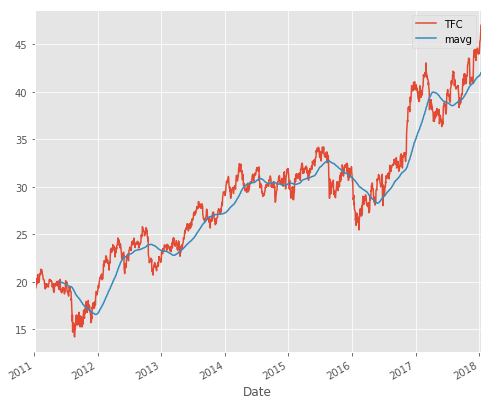

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
from pandas.plotting import scatter_matrix

#adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8,7))
mpl.__version__

#adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='TFC')
mavg.plot(label='mavg')
plt.legend()

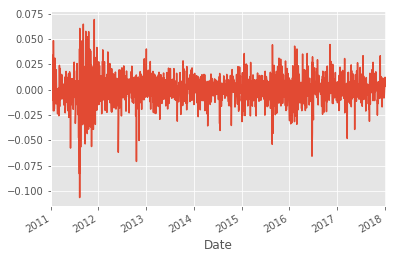

In [7]:
rets = close_px / close_px.shift(1) - 1

rets.plot(label='return')

In [8]:
dfcomp = web.DataReader(['JPM', 'PNC', 'RF', 'TFC', 'WFC'], 'yahoo', start=start, end=end)['Adj Close']
dfcomp.tail()

Symbols,JPM,PNC,RF,TFC,WFC
Date,,,,,
2018-01-05,98.332489,129.676956,15.544390,45.297695,56.049923
2018-01-08,98.477707,129.918808,15.526613,45.536430,55.415730
2018-01-09,98.976906,132.399841,15.802130,46.058113,55.612240
2018-01-10,100.066071,134.012054,16.068754,46.606316,56.380413
2018-01-11,100.601570,135.686966,16.175407,47.004211,56.282158


In [9]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

Symbols,JPM,PNC,RF,TFC,WFC
Symbols,,,,,
JPM,1.000000,0.781347,0.766307,0.774654,0.800718
PNC,0.781347,1.000000,0.790206,0.844248,0.816914
RF,0.766307,0.790206,1.000000,0.802827,0.767044
TFC,0.774654,0.844248,0.802827,1.000000,0.809145
WFC,0.800718,0.816914,0.767044,0.809145,1.000000


Text(0, 0.5, 'Returns WFC')

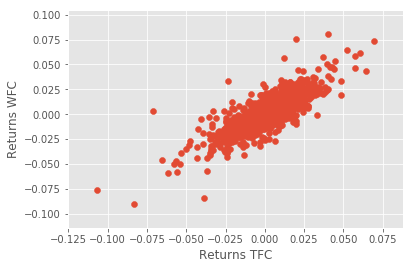

In [10]:
plt.scatter(retscomp.TFC, retscomp.WFC)
plt.xlabel('Returns TFC')
plt.ylabel('Returns WFC')

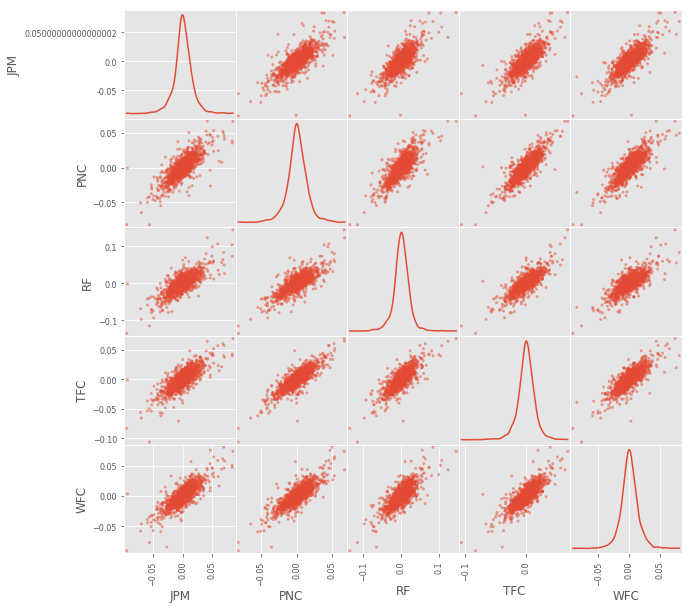

In [11]:
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10))
plt.show()

([<matplotlib.axis.YTick at 0x80c5e12668>,
 <a list of 5 Text yticklabel objects>)

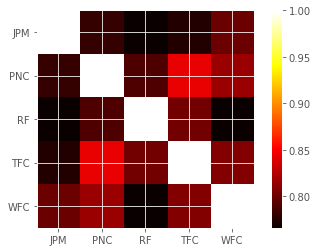

In [12]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)

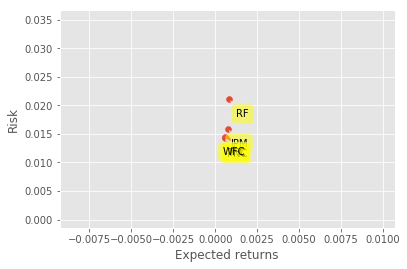

In [13]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
    label,
    xy = (x,y), xytext=(20, -20),
    textcoords = 'offset points', ha='right', va='bottom',
    bbox = dict(boxstyle='round, pad=0.5', fc='yellow', alpha=0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )

In [14]:
dfreg = df.loc[:, ['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2011-01-03,19.511986,6263700.0,2.232975,0.863369
2011-01-04,19.490200,6459200.0,2.123695,-0.592592
2011-01-05,20.059786,7948500.0,3.640335,3.270673
2011-01-06,19.636240,7012600.0,3.123838,-1.573940
2011-01-07,19.227308,7239300.0,3.266239,-1.496445


In [21]:
import math
from sklearn.preprocessing import scale

dfreg.fillna(value=-99999, inplace=True)

forecast_out = int(math.ceil(0.01 * len(dfreg)))

forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

X = scale(X)

X_lately = X[-forecast_out:]
X = X[:-forecast_out]

y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.20, random_state=42)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#linear regression
clfreg = LinearRegression(n_jobs=1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
#quadratic regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

#quadratic regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [28]:
#knn regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [31]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test, y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [32]:
print(confidencereg, confidencepoly2, confidencepoly3, confidenceknn)

0.9520249086308699 0.9514218907076739 0.9511550108497407 0.9286983063882205


In [34]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

In [44]:
forecast_set

array([44.14222852, 44.37737187, 44.36673517, 44.22087566, 44.68678912,
       44.72067315, 44.34090665, 44.29557686, 44.39756634, 44.07685035,
       44.24857665, 44.79147205, 45.34195236, 45.44598509, 45.67707624,
       46.24971266, 46.8164713 , 47.1494283 ])

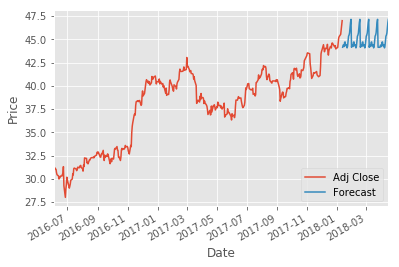

In [47]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns) - 1)] + [i]
    


dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()